In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple, Optional
import gc
import warnings
warnings.filterwarnings('ignore')

try:
    import umap
    UMAP_AVAILABLE = True
except:
    UMAP_AVAILABLE = False

torch.manual_seed(42)
np.random.seed(42)

# GPU Setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected - using CPU")
print(f"\n📍 Using device: {DEVICE}")

🎮 GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.2 GB

📍 Using device: cuda


In [3]:
class MarketBasketDataset:
    """Container for market basket data with negative sampling support."""

    def __init__(self, baskets: List[Dict[int, int]], n_items: int):
        self.baskets = baskets
        self.n_items = n_items
        self.item_freq = self._compute_item_freq()

        # Negative sampling distribution: freq^0.75 (word2vec style)
        self.neg_weights = np.power(self.item_freq + 1, 0.75)
        self.neg_weights /= self.neg_weights.sum()

    def _compute_item_freq(self):
        freq = np.zeros(self.n_items)
        for basket in self.baskets:
            for idx in basket:
                freq[idx] += 1
        return freq

    def get_context_target_pairs(self):
        """Generate (context, target_idx, target_qty) tuples for evaluation."""
        pairs = []
        for basket in self.baskets:
            if len(basket) < 2:
                continue
            items = list(basket.items())
            for i, (target_idx, target_qty) in enumerate(items):
                context = [(idx, qty) for j, (idx, qty) in enumerate(items) if j != i]
                pairs.append((context, target_idx, target_qty))
        return pairs


class MarketBasketData:
    """Load and preprocess market basket data."""

    def __init__(self, df, basket_col='basket_id', item_col='product_id',
                 name_col='product_name', qty_col='quantity',
                 min_item_freq=5, min_basket_size=2):

        self.basket_col = basket_col
        self.item_col = item_col
        self.name_col = name_col
        self.qty_col = qty_col

        # Filter out zero quantities
        df = df[df[qty_col] > 0].copy()

        # Filter by item frequency
        item_counts = df.groupby(item_col)[basket_col].nunique()
        valid_items = item_counts[item_counts >= min_item_freq].index
        df = df[df[item_col].isin(valid_items)]

        # Filter by basket size
        basket_sizes = df.groupby(basket_col)[item_col].nunique()
        valid_baskets = basket_sizes[basket_sizes >= min_basket_size].index
        df = df[df[basket_col].isin(valid_baskets)]
        self.df = df

        # Build mappings
        unique_items = df[item_col].unique()
        self.item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
        self.idx_to_item = {idx: item for item, idx in self.item_to_idx.items()}
        self.n_items = len(unique_items)

        # Item names
        if name_col in df.columns:
            item_names = df.groupby(item_col)[name_col].first()
            self.idx_to_name = {self.item_to_idx[item]: name for item, name in item_names.items()}
        else:
            self.idx_to_name = {idx: str(self.idx_to_item[idx]) for idx in range(self.n_items)}

        # Build baskets
        self.baskets = []
        for _, group in df.groupby(basket_col):
            basket = {}
            for _, row in group.iterrows():
                idx = self.item_to_idx[row[item_col]]
                qty = row[qty_col]
                basket[idx] = basket.get(idx, 0) + qty
            self.baskets.append(basket)

        print(f"📦 Dataset: {len(self.baskets)} baskets, {self.n_items} items")

    def train_val_test_split(self, test_frac=0.05, val_frac=0.05, seed=42):
        np.random.seed(seed)
        n = len(self.baskets)
        idx = np.random.permutation(n)
        n_test = int(n * test_frac)
        n_val = int(n * val_frac)

        test = MarketBasketDataset([self.baskets[i] for i in idx[:n_test]], self.n_items)
        val = MarketBasketDataset([self.baskets[i] for i in idx[n_test:n_test+n_val]], self.n_items)
        train = MarketBasketDataset([self.baskets[i] for i in idx[n_test+n_val:]], self.n_items)

        print(f"📊 Split: {len(train.baskets)} train, {len(val.baskets)} val, {len(test.baskets)} test")
        return train, val, test

In [4]:
class BasketBatchDataset(Dataset):
    """
    PyTorch Dataset for memory-efficient mini-batch training.

    CORRECTED: Stores raw quantities (x_j), not normalized weights.
    Context normalization by |c_i| is done in the model.
    """

    def __init__(self, basket_data, max_context=50):
        self.max_context = max_context
        self.samples = []

        # Pre-generate all (context, target) pairs
        for basket in basket_data.baskets:
            if len(basket) < 2:
                continue
            items = list(basket.items())
            for i, (target_idx, target_qty) in enumerate(items):
                context = [(idx, qty) for j, (idx, qty) in enumerate(items) if j != i]
                self.samples.append((context, target_idx, target_qty))

        print(f"📝 Created {len(self.samples)} training samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        context, target_idx, target_qty = self.samples[idx]

        # Pad context to fixed size
        ctx_idx = np.zeros(self.max_context, dtype=np.int64)
        ctx_qty = np.zeros(self.max_context, dtype=np.float32)  # RAW quantities
        n_ctx = min(len(context), self.max_context)

        for i in range(n_ctx):
            ctx_idx[i] = context[i][0]
            ctx_qty[i] = context[i][1]  # Store raw quantity x_j

        # DO NOT normalize here - let model handle it

        return {
            'ctx_idx': ctx_idx,
            'ctx_qty': ctx_qty,  # Raw quantities
            'n_ctx': n_ctx,      # Context size |c_i|
            'target_idx': target_idx,
            'target_qty': target_qty
        }


def create_dataloader(basket_data, batch_size=1024, shuffle=True):
    dataset = BasketBatchDataset(basket_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=0, pin_memory=True)

In [5]:
df = pd.read_csv('data.csv')
df = df[df['quantity'] > 0]
df.describe()

,product_id,household_key,basket_id,quantity
count,6.810290e+05,681029.000000,6.810290e+05,681029.00000
mean,2.628948e+06,1273.801685,3.401829e+10,1.31934
std,3.660973e+06,727.036593,4.704897e+09,0.92928
min,2.827200e+04,1.000000,2.698485e+10,1.00000
25%,9.082130e+05,654.000000,3.040817e+10,1.00000
50%,1.009482e+06,1277.000000,3.275979e+10,1.00000
75%,1.114263e+06,1918.000000,4.012678e+10,1.00000
max,1.824348e+07,2500.000000,4.230271e+10,72.00000


In [6]:
# Load and preprocess

data = MarketBasketData(df, min_item_freq=60, min_basket_size=5)
train_data, val_data, test_data = data.train_val_test_split()

📦 Dataset: 38459 baskets, 2388 items
📊 Split: 34615 train, 1922 val, 1922 test


## HPF Model

In [7]:
class HPF_MiniBatch(nn.Module):
    """Hierarchical Poisson Factorization (Baseline)."""

    def __init__(self, n_items, n_factors=50, a=0.3, b=0.3, device=DEVICE):
        super().__init__()
        self.n_items = n_items
        self.K = n_factors
        self.a, self.b = a, b
        self.device = device

        self.lambda_shape = nn.Parameter(
            torch.abs(torch.randn(n_items, n_factors, device=device)) + 1.0,
            requires_grad=False)
        self.lambda_rate = nn.Parameter(
            torch.abs(torch.randn(n_items, n_factors, device=device)) + 1.0,
            requires_grad=False)
        self.train_history = []

    @property
    def E_beta(self):
        return self.lambda_shape / self.lambda_rate

    @property
    def E_log_beta(self):
        return torch.digamma(self.lambda_shape) - torch.log(self.lambda_rate)

    def infer_user_factors(self, ctx_idx, ctx_qty, n_ctx, n_iter=10):
        batch_size = ctx_idx.shape[0]
        gamma_shape = torch.full((batch_size, self.K), self.a, device=self.device)
        gamma_rate = torch.full((batch_size, self.K), self.b, device=self.device)

        ctx_beta = self.E_beta[ctx_idx]
        ctx_log_beta = self.E_log_beta[ctx_idx]
        mask = (torch.arange(ctx_idx.shape[1], device=self.device).unsqueeze(0) <
                n_ctx.unsqueeze(1)).unsqueeze(2).float()

        for _ in range(n_iter):
            gamma_rate = self.b + (ctx_beta * mask).sum(dim=1)
            E_log_theta = torch.digamma(gamma_shape) - torch.log(gamma_rate)
            log_phi = E_log_theta.unsqueeze(1) + ctx_log_beta
            log_phi = log_phi - log_phi.max(dim=2, keepdim=True)[0]
            phi = torch.exp(log_phi)
            phi = phi / (phi.sum(dim=2, keepdim=True) + 1e-10)
            gamma_shape = self.a + (ctx_qty.unsqueeze(2) * phi * mask).sum(dim=1)

        return gamma_shape / gamma_rate

    def fit(self, train_data, n_epochs=50, batch_size=1024, lr=0.01,
            n_neg=10, patience=10, verbose=True):
        dataloader = create_dataloader(train_data, batch_size=batch_size)
        neg_weights = torch.tensor(train_data.neg_weights, dtype=torch.float32, device=self.device)

        best_loss, wait = float('inf'), 0
        pbar = tqdm(range(n_epochs), desc="HPF", disable=not verbose)

        for epoch in pbar:
            epoch_loss, n_batch = 0.0, 0

            for batch in dataloader:
                ctx_idx = batch['ctx_idx'].to(self.device)
                ctx_qty = batch['ctx_qty'].to(self.device)
                n_ctx = batch['n_ctx'].to(self.device)
                target_idx = batch['target_idx'].to(self.device)
                target_qty = batch['target_qty'].float().to(self.device)
                bs = target_idx.shape[0]

                E_theta = self.infer_user_factors(ctx_idx, ctx_qty, n_ctx)
                E_beta_target = self.E_beta[target_idx]
                lambda_target = (E_theta * E_beta_target).sum(dim=1)

                neg_idx = torch.multinomial(neg_weights, bs * n_neg, replacement=True).view(bs, n_neg)
                E_beta_neg = self.E_beta[neg_idx]
                lambda_neg = (E_theta.unsqueeze(1) * E_beta_neg).sum(dim=2)

                loss_pos = -target_qty * torch.log(lambda_target + 1e-10) + lambda_target
                loss_neg = lambda_neg.sum(dim=1)
                loss = (loss_pos + loss_neg).mean()

                with torch.no_grad():
                    grad = (target_qty - lambda_target).unsqueeze(1) * E_theta
                    for i in range(bs):
                        self.lambda_shape.data[target_idx[i]] += lr * grad[i]
                        self.lambda_shape.data[target_idx[i]] = torch.clamp(
                            self.lambda_shape.data[target_idx[i]], min=0.1)

                epoch_loss += loss.item()
                n_batch += 1

            avg_loss = epoch_loss / n_batch
            self.train_history.append(avg_loss)
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

            if avg_loss < best_loss:
                best_loss, wait = avg_loss, 0
            else:
                wait += 1
                if wait >= patience:
                    if verbose: print(f"\n⏹️ Early stopping at epoch {epoch}")
                    break
        return self

    def get_item_embeddings(self):
        return self.E_beta.detach().cpu().numpy()

    def recover_user_factors(self, context, n_iter=30):
        if len(context) == 0:
            return np.zeros(self.K)
        with torch.no_grad():
            n = len(context)
            ctx_idx = torch.zeros(1, n, dtype=torch.long, device=self.device)
            ctx_qty = torch.zeros(1, n, dtype=torch.float32, device=self.device)
            for i, (idx, qty) in enumerate(context):
                ctx_idx[0, i] = idx
                ctx_qty[0, i] = qty
            n_ctx = torch.tensor([n], device=self.device)
            E_theta = self.infer_user_factors(ctx_idx, ctx_qty, n_ctx, n_iter)
            return E_theta[0].cpu().numpy()

    def predict_rate(self, user_factors, item_idx):
        beta = self.E_beta[item_idx].detach().cpu().numpy()
        return np.dot(user_factors, beta)

    def predict_all_rates(self, user_factors):
        beta = self.E_beta.detach().cpu().numpy()
        return user_factors @ beta.T

## Poisson PCA Model

In [8]:
class PoissonPCA_MiniBatch(nn.Module):
    """Poisson PCA Baseline."""

    def __init__(self, n_items, n_factors=50, reg=0.01, device=DEVICE):
        super().__init__()
        self.n_items = n_items
        self.K = n_factors
        self.reg = reg
        self.device = device

        scale = 0.1 / np.sqrt(n_factors)
        self.H = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)
        self.c_i = nn.Parameter(torch.zeros(n_items, device=device))
        self.mu = nn.Parameter(torch.tensor(0.0, device=device))
        self.train_history = []

    def infer_user_factors(self, ctx_idx, ctx_qty, n_ctx):
        # Weighted average for Poisson PCA
        ctx_H = self.H[ctx_idx]
        total_qty = ctx_qty.sum(dim=1, keepdim=True) + 1e-10
        weights = ctx_qty / total_qty
        return (weights.unsqueeze(2) * ctx_H).sum(dim=1)

    def forward(self, W, item_idx):
        if item_idx.dim() == 1:
            H_items = self.H[item_idx]
            c_items = self.c_i[item_idx]
            eta = (W * H_items).sum(dim=1) + c_items + self.mu
        else:
            H_items = self.H[item_idx]
            c_items = self.c_i[item_idx]
            eta = (W.unsqueeze(1) * H_items).sum(dim=2) + c_items + self.mu
        return torch.exp(torch.clamp(eta, -20, 20))

    def fit(self, train_data, n_epochs=50, batch_size=1024, lr=0.01,
            n_neg=10, patience=10, verbose=True):
        dataloader = create_dataloader(train_data, batch_size=batch_size)

        total_obs = sum(sum(b.values()) for b in train_data.baskets)
        total_pairs = sum(len(b) * (len(b) - 1) for b in train_data.baskets)
        with torch.no_grad():
            self.mu.data = torch.tensor(np.log(total_obs / (total_pairs + 1) + 1e-10), device=self.device)

        neg_weights = torch.tensor(train_data.neg_weights, dtype=torch.float32, device=self.device)
        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=self.reg)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

        best_loss, wait = float('inf'), 0
        pbar = tqdm(range(n_epochs), desc="Poisson-PCA", disable=not verbose)

        for epoch in pbar:
            epoch_loss, n_batch = 0.0, 0
            for batch in dataloader:
                optimizer.zero_grad()
                ctx_idx = batch['ctx_idx'].to(self.device)
                ctx_qty = batch['ctx_qty'].to(self.device)
                n_ctx = batch['n_ctx'].to(self.device)
                target_idx = batch['target_idx'].to(self.device)
                target_qty = batch['target_qty'].float().to(self.device)
                bs = target_idx.shape[0]

                W = self.infer_user_factors(ctx_idx, ctx_qty, n_ctx)
                lambda_pos = self.forward(W, target_idx)

                neg_idx = torch.multinomial(neg_weights, bs * n_neg, replacement=True).view(bs, n_neg)
                lambda_neg = self.forward(W, neg_idx)

                loss_pos = -target_qty * torch.log(lambda_pos + 1e-10) + lambda_pos
                loss_neg = lambda_neg.sum(dim=1)
                loss = (loss_pos + loss_neg).mean()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5.0)
                optimizer.step()

                epoch_loss += loss.item()
                n_batch += 1

            avg_loss = epoch_loss / n_batch
            self.train_history.append(avg_loss)
            scheduler.step(avg_loss)
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

            if avg_loss < best_loss:
                best_loss, wait = avg_loss, 0
            else:
                wait += 1
                if wait >= patience:
                    if verbose: print(f"\n⏹️ Early stopping at epoch {epoch}")
                    break
        return self

    def get_item_embeddings(self):
        return self.H.detach().cpu().numpy()

    def recover_user_factors(self, context, n_iter=50):
        if len(context) == 0:
            return np.zeros(self.K)
        with torch.no_grad():
            n = len(context)
            ctx_idx = torch.zeros(1, n, dtype=torch.long, device=self.device)
            ctx_qty = torch.zeros(1, n, dtype=torch.float32, device=self.device)
            for i, (idx, qty) in enumerate(context):
                ctx_idx[0, i] = idx
                ctx_qty[0, i] = qty
            n_ctx = torch.tensor([n], device=self.device)
            W = self.infer_user_factors(ctx_idx, ctx_qty, n_ctx)
            return W[0].cpu().numpy()

    def predict_rate(self, user_factors, item_idx):
        H = self.H[item_idx].detach().cpu().numpy()
        c = self.c_i[item_idx].item()
        mu = self.mu.item()
        eta = np.dot(user_factors, H) + c + mu
        return np.exp(np.clip(eta, -20, 20))

    def predict_all_rates(self, user_factors):
        H = self.H.detach().cpu().numpy()
        c = self.c_i.detach().cpu().numpy()
        mu = self.mu.item()
        eta = user_factors @ H.T + c + mu
        return np.exp(np.clip(eta, -20, 20))

## P-EMB Model

In [9]:
class PEMB_MiniBatch(nn.Module):
    """
    Poisson Embedding (P-EMB) - CORRECTED Implementation.

    From Rudolph et al. (2016), Equation 2:

    η_i = ρ_i^T @ ᾱ_c

    where ᾱ_c = (1/|c|) × Σ(x_j × α_j)

    - x_j: raw quantity of item j
    - |c|: context size (number of items)
    - λ = exp(η)
    """

    def __init__(self, n_items, n_factors=50, reg=1e-6, device=DEVICE):
        super().__init__()
        self.n_items = n_items
        self.K = n_factors
        self.reg = reg
        self.device = device

        # Initialize embeddings
        scale = 0.1 / np.sqrt(n_factors)
        self.rho = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)
        self.alpha = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)

        self.train_history = []

    def compute_context_vector(self, ctx_idx, ctx_qty, n_ctx):
        """
        CORRECTED: Compute context vector as per paper.

        ᾱ = (1/|c|) × Σ(x_j × α_j)

        Args:
            ctx_idx: (batch, max_context) - context item indices
            ctx_qty: (batch, max_context) - RAW quantities x_j
            n_ctx: (batch,) - context size |c|

        Returns:
            context_vec: (batch, K)
        """
        ctx_alpha = self.alpha[ctx_idx]  # (batch, max_ctx, K)

        # Multiply by raw quantities: x_j × α_j
        weighted = ctx_qty.unsqueeze(2) * ctx_alpha  # (batch, max_ctx, K)

        # Sum over context
        context_sum = weighted.sum(dim=1)  # (batch, K)

        # Divide by context SIZE (number of items), not total quantity
        # Add small epsilon to avoid division by zero
        context_vec = context_sum / (n_ctx.float().unsqueeze(1) + 1e-10)

        return context_vec

    def compute_lambda(self, target_idx, context_vec):
        """
        Compute Poisson rate: λ = exp(ρ_i^T @ ᾱ)
        """
        target_rho = self.rho[target_idx]

        if target_idx.dim() == 1:
            eta = (target_rho * context_vec).sum(dim=1)
        else:
            eta = (target_rho * context_vec.unsqueeze(1)).sum(dim=2)

        eta = torch.clamp(eta, -20, 20)
        return torch.exp(eta)

    def fit(self, train_data, n_epochs=50, batch_size=1024, lr=0.1,
            n_neg=10, patience=40, verbose=True):
        """Train P-EMB using Adagrad (as per paper)."""
        dataloader = create_dataloader(train_data, batch_size=batch_size)
        neg_weights = torch.tensor(train_data.neg_weights, dtype=torch.float32, device=self.device)

        # Paper uses Adagrad
        optimizer = optim.Adagrad(self.parameters(), lr=lr)

        best_loss, wait = float('inf'), 0
        pbar = tqdm(range(n_epochs), desc="P-EMB", disable=not verbose)

        for epoch in pbar:
            epoch_loss, n_batch = 0.0, 0

            for batch in dataloader:
                optimizer.zero_grad()

                ctx_idx = batch['ctx_idx'].to(self.device)
                ctx_qty = batch['ctx_qty'].to(self.device)  # Raw quantities
                n_ctx = batch['n_ctx'].to(self.device).float()  # Context size
                target_idx = batch['target_idx'].to(self.device)
                target_qty = batch['target_qty'].float().to(self.device)
                bs = target_idx.shape[0]

                # Compute context vector (CORRECTED)
                context_vec = self.compute_context_vector(ctx_idx, ctx_qty, n_ctx)

                # Positive samples
                lambda_pos = self.compute_lambda(target_idx, context_vec)
                loss_pos = -target_qty * torch.log(lambda_pos + 1e-10) + lambda_pos

                # Negative samples
                neg_idx = torch.multinomial(neg_weights, bs * n_neg, replacement=True).view(bs, n_neg)
                lambda_neg = self.compute_lambda(neg_idx, context_vec)
                loss_neg = lambda_neg.sum(dim=1)

                # Total loss + L2 regularization
                loss = (loss_pos + loss_neg).mean()
                reg_loss = self.reg * (self.rho.pow(2).sum() + self.alpha.pow(2).sum())
                total_loss = loss + reg_loss

                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5.0)
                optimizer.step()

                epoch_loss += loss.item()
                n_batch += 1

            avg_loss = epoch_loss / n_batch
            self.train_history.append(avg_loss)
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

            if avg_loss < best_loss:
                best_loss, wait = avg_loss, 0
            else:
                wait += 1
                if wait >= patience:
                    if verbose: print(f"\n⏹️ Early stopping at epoch {epoch}")
                    break

        return self

    def get_item_embeddings(self):
        return self.rho.detach().cpu().numpy()

    def get_context_embeddings(self):
        return self.alpha.detach().cpu().numpy()

    def recover_user_factors(self, context, n_iter=None):
        """Recover context vector for evaluation."""
        if len(context) == 0:
            return np.zeros(self.K)

        with torch.no_grad():
            n = len(context)
            ctx_idx = torch.zeros(1, n, dtype=torch.long, device=self.device)
            ctx_qty = torch.zeros(1, n, dtype=torch.float32, device=self.device)

            for i, (idx, qty) in enumerate(context):
                ctx_idx[0, i] = idx
                ctx_qty[0, i] = qty  # Raw quantity

            n_ctx = torch.tensor([n], dtype=torch.float32, device=self.device)
            context_vec = self.compute_context_vector(ctx_idx, ctx_qty, n_ctx)
            return context_vec[0].cpu().numpy()

    def predict_rate(self, user_factors, item_idx):
        rho = self.rho[item_idx].detach().cpu().numpy()
        eta = np.dot(rho, user_factors)
        return np.exp(np.clip(eta, -20, 20))

    def predict_all_rates(self, user_factors):
        rho = self.rho.detach().cpu().numpy()
        eta = rho @ user_factors
        return np.exp(np.clip(eta, -20, 20))

## P-EMB (downweighted) Model

In [10]:
class PEMB_Downweighted_MiniBatch(nn.Module):
    """
    P-EMB with Downweighted Zeros (CORRECTED).

    Same as P-EMB but zeros contribute with weight w₀ = 0.1
    """

    def __init__(self, n_items, n_factors=50, zero_weight=0.1, reg=1e-6, device=DEVICE):
        super().__init__()
        self.n_items = n_items
        self.K = n_factors
        self.zero_weight = zero_weight  # w₀ = 0.1 as per paper
        self.reg = reg
        self.device = device

        scale = 0.1 / np.sqrt(n_factors)
        self.rho = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)
        self.alpha = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)

        self.train_history = []

    def compute_context_vector(self, ctx_idx, ctx_qty, n_ctx):
        """CORRECTED: ᾱ = (1/|c|) × Σ(x_j × α_j)"""
        ctx_alpha = self.alpha[ctx_idx]
        weighted = ctx_qty.unsqueeze(2) * ctx_alpha
        context_sum = weighted.sum(dim=1)
        return context_sum / (n_ctx.float().unsqueeze(1) + 1e-10)

    def compute_lambda(self, target_idx, context_vec):
        target_rho = self.rho[target_idx]
        if target_idx.dim() == 1:
            eta = (target_rho * context_vec).sum(dim=1)
        else:
            eta = (target_rho * context_vec.unsqueeze(1)).sum(dim=2)
        eta = torch.clamp(eta, -20, 20)
        return torch.exp(eta)

    def fit(self, train_data, n_epochs=50, batch_size=1024, lr=0.1,
            n_neg=10, patience=40, verbose=True):
        dataloader = create_dataloader(train_data, batch_size=batch_size)
        neg_weights = torch.tensor(train_data.neg_weights, dtype=torch.float32, device=self.device)

        optimizer = optim.Adagrad(self.parameters(), lr=lr)

        best_loss, wait = float('inf'), 0
        pbar = tqdm(range(n_epochs), desc=f"P-EMB (w₀={self.zero_weight})", disable=not verbose)

        for epoch in pbar:
            epoch_loss, n_batch = 0.0, 0

            for batch in dataloader:
                optimizer.zero_grad()

                ctx_idx = batch['ctx_idx'].to(self.device)
                ctx_qty = batch['ctx_qty'].to(self.device)
                n_ctx = batch['n_ctx'].to(self.device).float()
                target_idx = batch['target_idx'].to(self.device)
                target_qty = batch['target_qty'].float().to(self.device)
                bs = target_idx.shape[0]

                context_vec = self.compute_context_vector(ctx_idx, ctx_qty, n_ctx)

                # Positive samples (full weight)
                lambda_pos = self.compute_lambda(target_idx, context_vec)
                loss_pos = -target_qty * torch.log(lambda_pos + 1e-10) + lambda_pos

                # Negative samples (DOWNWEIGHTED by w₀)
                neg_idx = torch.multinomial(neg_weights, bs * n_neg, replacement=True).view(bs, n_neg)
                lambda_neg = self.compute_lambda(neg_idx, context_vec)
                loss_neg = self.zero_weight * lambda_neg.sum(dim=1)  # ← w₀ × Σλ_neg

                loss = (loss_pos + loss_neg).mean()
                reg_loss = self.reg * (self.rho.pow(2).sum() + self.alpha.pow(2).sum())
                total_loss = loss + reg_loss

                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5.0)
                optimizer.step()

                epoch_loss += loss.item()
                n_batch += 1

            avg_loss = epoch_loss / n_batch
            self.train_history.append(avg_loss)
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

            if avg_loss < best_loss:
                best_loss, wait = avg_loss, 0
            else:
                wait += 1
                if wait >= patience:
                    if verbose: print(f"\n⏹️ Early stopping at epoch {epoch}")
                    break

        return self

    def get_item_embeddings(self):
        return self.rho.detach().cpu().numpy()

    def get_context_embeddings(self):
        return self.alpha.detach().cpu().numpy()

    def recover_user_factors(self, context, n_iter=None):
        if len(context) == 0:
            return np.zeros(self.K)
        with torch.no_grad():
            n = len(context)
            ctx_idx = torch.zeros(1, n, dtype=torch.long, device=self.device)
            ctx_qty = torch.zeros(1, n, dtype=torch.float32, device=self.device)
            for i, (idx, qty) in enumerate(context):
                ctx_idx[0, i] = idx
                ctx_qty[0, i] = qty
            n_ctx = torch.tensor([n], dtype=torch.float32, device=self.device)
            context_vec = self.compute_context_vector(ctx_idx, ctx_qty, n_ctx)
            return context_vec[0].cpu().numpy()

    def predict_rate(self, user_factors, item_idx):
        rho = self.rho[item_idx].detach().cpu().numpy()
        eta = np.dot(rho, user_factors)
        return np.exp(np.clip(eta, -20, 20))

    def predict_all_rates(self, user_factors):
        rho = self.rho.detach().cpu().numpy()
        eta = rho @ user_factors
        return np.exp(np.clip(eta, -20, 20))

## AP-EMB Model

In [11]:
class APEMB_MiniBatch(nn.Module):
    """
    Additive Poisson Embedding (AP-EMB) - CORRECTED Implementation.

    From Paper (Page 5):
    - Link function f(·) = log(·), so λ = ρ^T @ ᾱ directly (additive)
    - Parameters constrained to be NON-NEGATIVE
    - L2 regularization in LOG-SPACE (log-normal prior)

    Note: Can only capture POSITIVE correlations due to λ ≥ 0 constraint.
    """

    def __init__(self, n_items, n_factors=50, zero_weight=0.1, reg=1e-6, device=DEVICE):
        super().__init__()
        self.n_items = n_items
        self.K = n_factors
        self.zero_weight = zero_weight
        self.reg = reg
        self.device = device

        # Initialize with POSITIVE values (non-negative constraint)
        # Using exp of normal to ensure positivity
        scale = 0.1 / np.sqrt(n_factors)
        self.log_rho = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)
        self.log_alpha = nn.Parameter(torch.randn(n_items, n_factors, device=device) * scale)
        self.log_bias = nn.Parameter(torch.zeros(n_items, device=device))

        self.train_history = []

    @property
    def rho(self):
        """Non-negative rho = exp(log_rho)"""
        return torch.exp(self.log_rho)

    @property
    def alpha(self):
        """Non-negative alpha = exp(log_alpha)"""
        return torch.exp(self.log_alpha)

    @property
    def bias(self):
        """Non-negative bias = exp(log_bias)"""
        return torch.exp(self.log_bias)

    def compute_context_vector(self, ctx_idx, ctx_qty, n_ctx):
        """CORRECTED: ᾱ = (1/|c|) × Σ(x_j × α_j) with non-negative α"""
        ctx_alpha = self.alpha[ctx_idx]  # Non-negative
        weighted = ctx_qty.unsqueeze(2) * ctx_alpha
        context_sum = weighted.sum(dim=1)
        return context_sum / (n_ctx.float().unsqueeze(1) + 1e-10)

    def compute_lambda(self, target_idx, context_vec):
        """
        Compute λ = ρ_i^T @ ᾱ + b_i (ADDITIVE, not exp)

        Since all parameters are non-negative, λ ≥ 0 automatically.
        """
        target_rho = self.rho[target_idx]  # Non-negative
        target_bias = self.bias[target_idx]  # Non-negative

        if target_idx.dim() == 1:
            lam = (target_rho * context_vec).sum(dim=1) + target_bias
        else:
            lam = (target_rho * context_vec.unsqueeze(1)).sum(dim=2) + target_bias

        # Ensure minimum value for numerical stability
        return lam + 1e-10

    def fit(self, train_data, n_epochs=50, batch_size=1024, lr=0.1,
            n_neg=10, patience=40, verbose=True):
        dataloader = create_dataloader(train_data, batch_size=batch_size)
        neg_weights = torch.tensor(train_data.neg_weights, dtype=torch.float32, device=self.device)

        optimizer = optim.Adagrad(self.parameters(), lr=lr)

        best_loss, wait = float('inf'), 0
        pbar = tqdm(range(n_epochs), desc="AP-EMB", disable=not verbose)

        for epoch in pbar:
            epoch_loss, n_batch = 0.0, 0

            for batch in dataloader:
                optimizer.zero_grad()

                ctx_idx = batch['ctx_idx'].to(self.device)
                ctx_qty = batch['ctx_qty'].to(self.device)
                n_ctx = batch['n_ctx'].to(self.device).float()
                target_idx = batch['target_idx'].to(self.device)
                target_qty = batch['target_qty'].float().to(self.device)
                bs = target_idx.shape[0]

                context_vec = self.compute_context_vector(ctx_idx, ctx_qty, n_ctx)

                # Positive samples
                lambda_pos = self.compute_lambda(target_idx, context_vec)
                loss_pos = -target_qty * torch.log(lambda_pos + 1e-10) + lambda_pos

                # Negative samples (downweighted)
                neg_idx = torch.multinomial(neg_weights, bs * n_neg, replacement=True).view(bs, n_neg)
                lambda_neg = self.compute_lambda(neg_idx, context_vec)
                loss_neg = self.zero_weight * lambda_neg.sum(dim=1)

                loss = (loss_pos + loss_neg).mean()

                # L2 regularization in LOG-SPACE (as per paper)
                reg_loss = self.reg * (self.log_rho.pow(2).sum() + self.log_alpha.pow(2).sum())
                total_loss = loss + reg_loss

                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 5.0)
                optimizer.step()

                epoch_loss += loss.item()
                n_batch += 1

            avg_loss = epoch_loss / n_batch
            self.train_history.append(avg_loss)
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

            if avg_loss < best_loss:
                best_loss, wait = avg_loss, 0
            else:
                wait += 1
                if wait >= patience:
                    if verbose: print(f"\n⏹️ Early stopping at epoch {epoch}")
                    break

        return self

    def get_item_embeddings(self):
        return self.rho.detach().cpu().numpy()

    def get_context_embeddings(self):
        return self.alpha.detach().cpu().numpy()

    def recover_user_factors(self, context, n_iter=None):
        if len(context) == 0:
            return np.zeros(self.K)
        with torch.no_grad():
            n = len(context)
            ctx_idx = torch.zeros(1, n, dtype=torch.long, device=self.device)
            ctx_qty = torch.zeros(1, n, dtype=torch.float32, device=self.device)
            for i, (idx, qty) in enumerate(context):
                ctx_idx[0, i] = idx
                ctx_qty[0, i] = qty
            n_ctx = torch.tensor([n], dtype=torch.float32, device=self.device)
            context_vec = self.compute_context_vector(ctx_idx, ctx_qty, n_ctx)
            return context_vec[0].cpu().numpy()

    def predict_rate(self, user_factors, item_idx):
        rho = self.rho[item_idx].detach().cpu().numpy()
        b = self.bias[item_idx].item()
        lam = np.dot(rho, user_factors) + b
        return max(lam, 1e-10)

    def predict_all_rates(self, user_factors):
        rho = self.rho.detach().cpu().numpy()
        b = self.bias.detach().cpu().numpy()
        lam = rho @ user_factors + b
        return np.maximum(lam, 1e-10)

### Evaluation

In [12]:
def evaluate_model(model, test_data, n_bootstrap=100, max_samples=5000, verbose=True):
    """Evaluate using normalized log-likelihood with bootstrap SE."""
    pairs = test_data.get_context_target_pairs()

    if len(pairs) > max_samples:
        idx = np.random.choice(len(pairs), max_samples, replace=False)
        pairs = [pairs[i] for i in idx]

    norm_llhs = []

    for context, target_idx, target_qty in tqdm(pairs, desc="Evaluating", disable=not verbose):
        if len(context) == 0:
            continue

        uf = model.recover_user_factors(context)
        lam_target = model.predict_rate(uf, target_idx)
        lam_all = model.predict_all_rates(uf)
        lam_sum = lam_all.sum()

        norm_llh = np.log(lam_target / (lam_sum + 1e-10) + 1e-10)
        norm_llhs.append(norm_llh)

    norm_llhs = np.array(norm_llhs)

    n_obs = len(norm_llhs)
    boot_means = [norm_llhs[np.random.choice(n_obs, n_obs, replace=True)].mean()
                  for _ in range(n_bootstrap)]

    return {
        'normalized_llh': norm_llhs.mean(),
        'normalized_llh_se': np.std(boot_means),
        'n_obs': n_obs
    }

def format_result(val, se):
    return f"{val:.4f} ± {se:.4f}"

### Visualization Function

In [13]:
class EmbeddingVisualizer:
    def __init__(self, embeddings, idx_to_name, item_freq=None):
        self.embeddings = embeddings
        self.idx_to_name = idx_to_name
        self.n_items, self.K = embeddings.shape
        self.item_freq = item_freq if item_freq is not None else np.ones(self.n_items)
        self._cache = {}

    def get_projection(self, method='tsne'):
        if method not in self._cache:
            if method == 'pca':
                self._cache[method] = PCA(n_components=2).fit_transform(self.embeddings)
            elif method == 'tsne':
                perp = min(30, self.n_items - 1)
                self._cache[method] = TSNE(n_components=2, perplexity=perp,
                                           random_state=42).fit_transform(self.embeddings)
        return self._cache.get(method)

    def plot_2d(self, method='tsne', n_clusters=10, title=None, figsize=(10, 7)):
        proj = self.get_projection(method)
        clusters = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(self.embeddings)

        fig, ax = plt.subplots(figsize=figsize)
        scatter = ax.scatter(proj[:, 0], proj[:, 1], c=clusters, cmap='tab10',
                            s=np.log1p(self.item_freq) * 10, alpha=0.7)
        plt.colorbar(scatter, label='Cluster')
        ax.set_title(title or f'{method.upper()} Projection')
        plt.tight_layout()
        return fig

In [14]:
# Configuration
K_VALUES = [10, 20, 50]
BATCH_SIZE = 2048
N_NEG = 5
N_EPOCHS = 100  # More epochs
PATIENCE = 50

results = {}
trained_models = {}

ALL_MODELS = ['HPF', 'Poisson-PCA', 'P-EMB', 'P-EMB-DW', 'AP-EMB']

print(f"🎯 Embedding dimensions: {K_VALUES}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"➖ Negative samples: {N_NEG}")
print(f"📍 Device: {DEVICE}")

🎯 Embedding dimensions: [10, 20, 50]
📦 Batch size: 2048
➖ Negative samples: 5
📍 Device: cuda


In [15]:
# Train HPF
print("\n" + "="*60)
print("🔷 Training HPF (Baseline)")
print("="*60)

results['HPF'] = {}
trained_models['HPF'] = {}

for K in K_VALUES:
    print(f"\n--- K = {K} ---")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

    model = HPF_MiniBatch(n_items=data.n_items, n_factors=K, device=DEVICE)
    model.fit(train_data, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_neg=N_NEG, patience=PATIENCE)

    metrics = evaluate_model(model, test_data)
    results['HPF'][K] = metrics
    trained_models['HPF'][K] = model
    print(f"✅ HPF (K={K}): NLL = {format_result(metrics['normalized_llh'], metrics['normalized_llh_se'])}")


🔷 Training HPF (Baseline)

--- K = 10 ---
📝 Created 284964 training samples


HPF:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ HPF (K=10): NLL = -7.7895 ± 0.0042

--- K = 20 ---
📝 Created 284964 training samples


HPF:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ HPF (K=20): NLL = -7.7941 ± 0.0040

--- K = 50 ---
📝 Created 284964 training samples


HPF:   0%|          | 0/100 [00:00<?, ?it/s]


⏹️ Early stopping at epoch 62


Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ HPF (K=50): NLL = -7.7708 ± 0.0026


In [16]:
# Train Poisson PCA
print("\n" + "="*60)
print("🔶 Training Poisson PCA")
print("="*60)

results['Poisson-PCA'] = {}
trained_models['Poisson-PCA'] = {}

for K in K_VALUES:
    print(f"\n--- K = {K} ---")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

    model = PoissonPCA_MiniBatch(n_items=data.n_items, n_factors=K, device=DEVICE)
    model.fit(train_data, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_neg=N_NEG, patience=PATIENCE)

    metrics = evaluate_model(model, test_data)
    results['Poisson-PCA'][K] = metrics
    trained_models['Poisson-PCA'][K] = model
    print(f"✅ Poisson-PCA (K={K}): {format_result(metrics['normalized_llh'], metrics['normalized_llh_se'])}")


🔶 Training Poisson PCA

--- K = 10 ---
📝 Created 284964 training samples


Poisson-PCA:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ Poisson-PCA (K=10): -7.2867 ± 0.0115

--- K = 20 ---
📝 Created 284964 training samples


Poisson-PCA:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ Poisson-PCA (K=20): -7.2545 ± 0.0125

--- K = 50 ---
📝 Created 284964 training samples


Poisson-PCA:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ Poisson-PCA (K=50): -7.2244 ± 0.0139


In [28]:
# Train P-EMB (Multiplicative Poisson Embedding)
print("\n" + "="*60)
print("🟢 Training P-EMB (Multiplicative)")
print("="*60)

results['P-EMB'] = {}
trained_models['P-EMB'] = {}

for K in K_VALUES:
    print(f"\n--- K = {K} ---")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

    model = PEMB_MiniBatch(n_items=data.n_items, n_factors=K, device=DEVICE)
    model.fit(train_data, n_epochs=200, batch_size=BATCH_SIZE, n_neg=N_NEG, patience=100)

    metrics = evaluate_model(model, test_data)
    results['P-EMB'][K] = metrics
    trained_models['P-EMB'][K] = model
    print(f"✅ P-EMB (K={K}): NLL = {format_result(metrics['normalized_llh'], metrics['normalized_llh_se'])}")


🟢 Training P-EMB (Multiplicative)

--- K = 10 ---
📝 Created 284964 training samples


P-EMB:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ P-EMB (K=10): NLL = -7.3050 ± 0.0120

--- K = 20 ---
📝 Created 284964 training samples


P-EMB:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ P-EMB (K=20): NLL = -7.2898 ± 0.0139

--- K = 50 ---
📝 Created 284964 training samples


P-EMB:   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ P-EMB (K=50): NLL = -7.2985 ± 0.0163


In [27]:
# Train P-EMB Downweighted (CORRECTED)
print("\n" + "="*60)
print("🟡 Training P-EMB Downweighted (w₀=0.1)")
print("="*60)

results['P-EMB-DW'] = {}
trained_models['P-EMB-DW'] = {}

for K in K_VALUES:
    print(f"\n--- K = {K} ---")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

    model = PEMB_Downweighted_MiniBatch(n_items=data.n_items, n_factors=K, zero_weight=0.1, device=DEVICE)
    model.fit(train_data, n_epochs=200, batch_size=BATCH_SIZE, lr=0.05, n_neg=10, patience=PATIENCE)

    metrics = evaluate_model(model, test_data)
    results['P-EMB-DW'][K] = metrics
    trained_models['P-EMB-DW'][K] = model
    print(f"✅ P-EMB-DW (K={K}): {format_result(metrics['normalized_llh'], metrics['normalized_llh_se'])}")


🟡 Training P-EMB Downweighted (w₀=0.1)

--- K = 10 ---
📝 Created 284964 training samples


P-EMB (w₀=0.1):   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ P-EMB-DW (K=10): -7.4544 ± 0.0077

--- K = 20 ---
📝 Created 284964 training samples


P-EMB (w₀=0.1):   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ P-EMB-DW (K=20): -7.4074 ± 0.0081

--- K = 50 ---
📝 Created 284964 training samples


P-EMB (w₀=0.1):   0%|          | 0/200 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ P-EMB-DW (K=50): -7.3519 ± 0.0129


In [19]:
# Train AP-EMB (CORRECTED)
print("\n" + "="*60)
print("🔴 Training AP-EMB (CORRECTED)")
print("="*60)

results['AP-EMB'] = {}
trained_models['AP-EMB'] = {}

for K in K_VALUES:
    print(f"\n--- K = {K} ---")
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

    model = APEMB_MiniBatch(n_items=data.n_items, n_factors=K, zero_weight=0.1, device=DEVICE)
    model.fit(train_data, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, lr=0.05, n_neg=5, patience=PATIENCE)

    metrics = evaluate_model(model, test_data)
    results['AP-EMB'][K] = metrics
    trained_models['AP-EMB'][K] = model
    print(f"✅ AP-EMB (K={K}): {format_result(metrics['normalized_llh'], metrics['normalized_llh_se'])}")


🔴 Training AP-EMB (CORRECTED)

--- K = 10 ---
📝 Created 284964 training samples


AP-EMB:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ AP-EMB (K=10): -7.7368 ± 0.0032

--- K = 20 ---
📝 Created 284964 training samples


AP-EMB:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ AP-EMB (K=20): -7.7910 ± 0.0031

--- K = 50 ---
📝 Created 284964 training samples


AP-EMB:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ AP-EMB (K=50): -7.9057 ± 0.0029


In [20]:
print("\n" + "="*80)
print("📈 RESULTS: Normalized Log-Likelihood (higher is better)")
print("="*80)

header = f"{'Model':<20}"
for K in K_VALUES:
    header += f"{'K='+str(K):>20}"
print(header)
print("-"*80)

for model_name in ALL_MODELS:
    row = f"{model_name:<20}"
    for K in K_VALUES:
        if model_name in results and K in results[model_name]:
            m = results[model_name][K]
            row += f"{format_result(m['normalized_llh'], m['normalized_llh_se']):>20}"
        else:
            row += f"{'N/A':>20}"
    print(row)

print("="*80)


📈 RESULTS: Normalized Log-Likelihood (higher is better)
Model                               K=10                K=20                K=50
--------------------------------------------------------------------------------
HPF                     -7.7895 ± 0.0042    -7.7941 ± 0.0040    -7.7708 ± 0.0026
Poisson-PCA             -7.2867 ± 0.0115    -7.2545 ± 0.0125    -7.2244 ± 0.0139
P-EMB                   -7.3195 ± 0.0101    -7.2674 ± 0.0121    -7.3117 ± 0.0156
P-EMB-DW                -7.3914 ± 0.0081    -7.3388 ± 0.0099    -7.2846 ± 0.0137
AP-EMB                  -7.7368 ± 0.0032    -7.7910 ± 0.0031    -7.9057 ± 0.0029


In [21]:
# Create results DataFrame
results_df = []
for model_name in ALL_MODELS:
    for K in K_VALUES:
        if model_name in results and K in results[model_name]:
            m = results[model_name][K]
            results_df.append({
                'Model': model_name,
                'K': K,
                'Normalized_LLH': m['normalized_llh'],
                'SE': m['normalized_llh_se']
            })

results_df = pd.DataFrame(results_df)
results_df

,Model,K,Normalized_LLH,SE
0,HPF,10,-7.789451,0.004198
1,HPF,20,-7.794053,0.004006
2,HPF,50,-7.770810,0.002588
3,Poisson-PCA,10,-7.286685,0.011487
4,Poisson-PCA,20,-7.254497,0.012468
5,Poisson-PCA,50,-7.224402,0.013851
6,P-EMB,10,-7.319482,0.010111
7,P-EMB,20,-7.267391,0.012065
8,P-EMB,50,-7.311674,0.015597
9,P-EMB-DW,10,-7.391438,0.008148


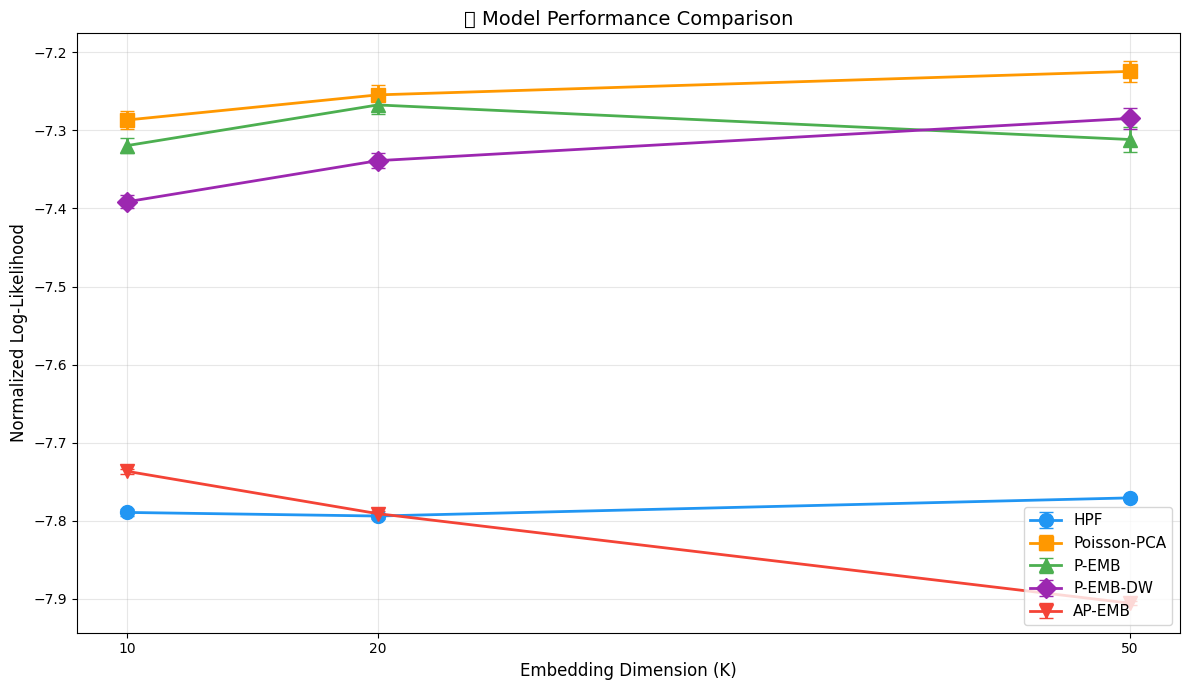

In [29]:
# Performance comparison plot
fig, ax = plt.subplots(figsize=(12, 7))

colors = {
    'HPF': '#2196F3',
    'Poisson-PCA': '#FF9800',
    'P-EMB': '#4CAF50',
    'P-EMB-DW': '#9C27B0',
    'AP-EMB': '#F44336'
}
markers = {
    'HPF': 'o',
    'Poisson-PCA': 's',
    'P-EMB': '^',
    'P-EMB-DW': 'D',
    'AP-EMB': 'v'
}

for model_name in ALL_MODELS:
    model_df = results_df[results_df['Model'] == model_name]
    if len(model_df) > 0:
        ax.errorbar(model_df['K'], model_df['Normalized_LLH'],
                    yerr=model_df['SE'], marker=markers.get(model_name, 'o'),
                    capsize=5, label=model_name, linewidth=2, markersize=10,
                    color=colors.get(model_name, 'gray'))

ax.set_xlabel('Embedding Dimension (K)', fontsize=12)
ax.set_ylabel('Normalized Log-Likelihood', fontsize=12)
ax.set_title('🎯 Model Performance Comparison', fontsize=14)
ax.legend(fontsize=11, loc='lower right')
ax.set_xticks(K_VALUES)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

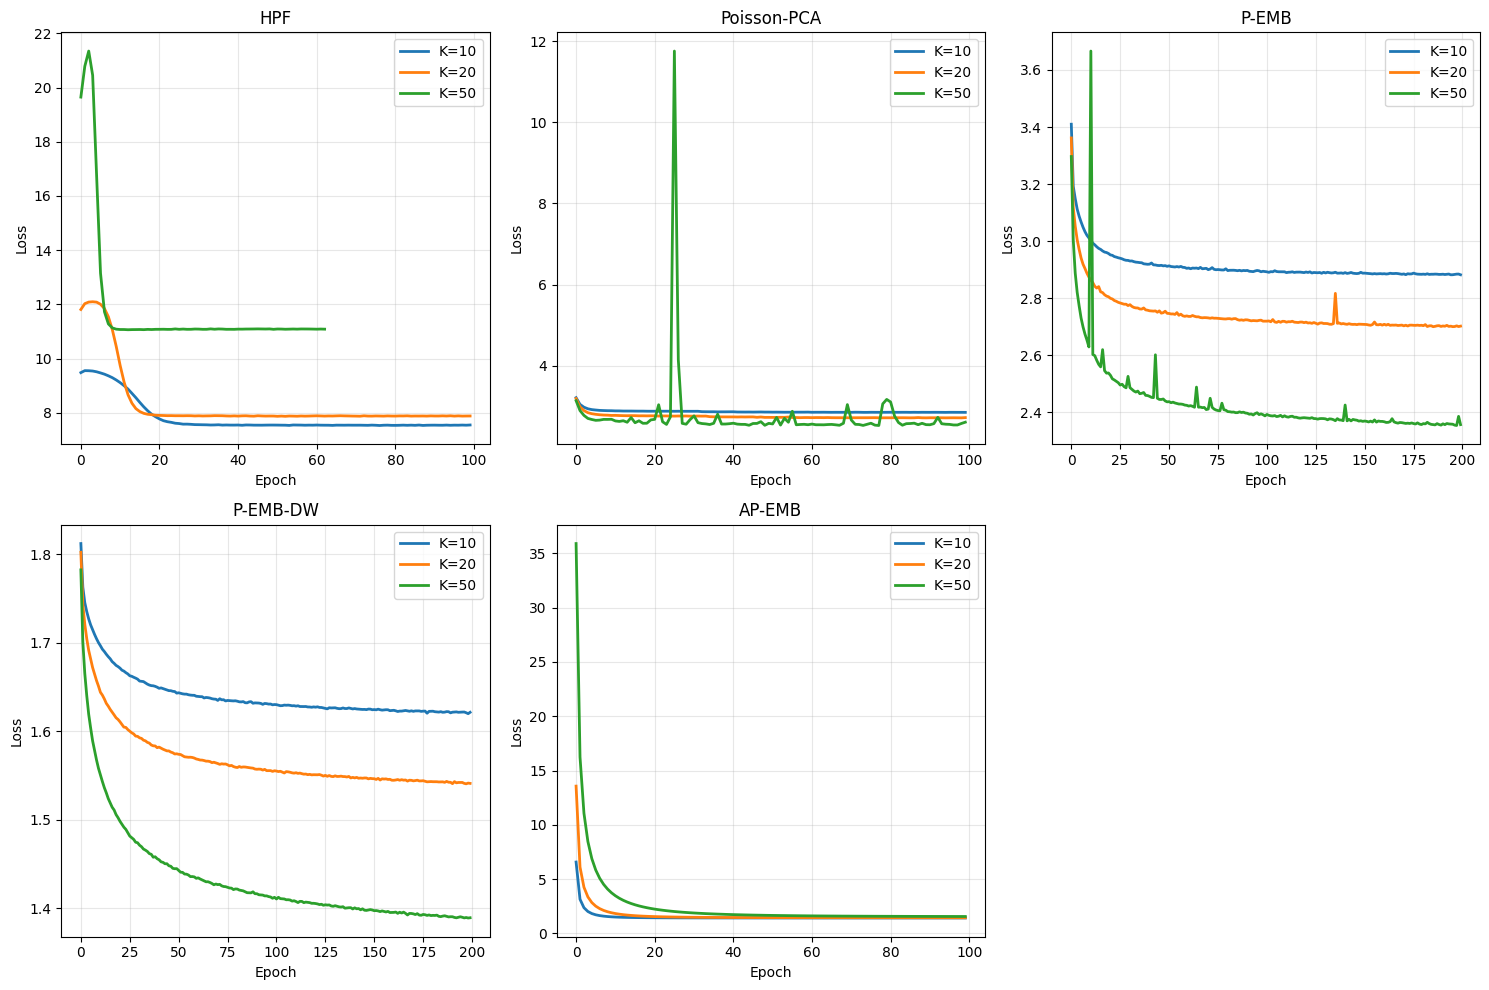

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, model_name in enumerate(ALL_MODELS):
    ax = axes[idx]
    for K in K_VALUES:
        if model_name in trained_models and K in trained_models[model_name]:
            model = trained_models[model_name][K]
            ax.plot(model.train_history, label=f'K={K}', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide last subplot if odd number of models
if len(ALL_MODELS) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()